<h1 style="text-align:center;font-size:30px;" > Self Driving Car </h1>

<h2>Problem Statement:</h2>

Given the front camera view of a car, we need to predict the steering angle to which the steering needs to rotate. This is a minimal version of self driving car.

### 1. Loading the Data

In [1]:
# Importing Required Packages
import tensorflow as tf
import os
from tensorflow.core.protobuf import saver_pb2
import driving_data
import scipy.misc
import model
import os
import numpy as np
import random
from scipy import pi
from itertools import islice
import cv2
from subprocess import call
import model
import scipy
import scipy.misc
import random
import warnings
import matplotlib.pyplot as plt 
%matplotlib inline
warnings.filterwarnings('ignore')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [2]:
xs = []
ys = []

#points to the end of the last batch
train_batch_pointer = 0
val_batch_pointer = 0

#read data.txt
with open("driving_dataset/data.txt") as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)


train_xs = xs[:int(len(xs) * 0.7)]
train_ys = ys[:int(len(xs) * 0.7)]

val_xs = xs[-int(len(xs) * 0.3):]
val_ys = ys[-int(len(xs) * 0.3):]

num_train_images = len(train_xs)
num_val_images = len(val_xs)

def LoadTrainBatch(batch_size):
    global train_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(train_xs[(train_batch_pointer + i) % num_train_images])[-150:], [66, 200]) / 255.0)
        y_out.append([train_ys[(train_batch_pointer + i) % num_train_images]])
    train_batch_pointer += batch_size
    return x_out, y_out

def LoadValBatch(batch_size):
    global val_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(val_xs[(val_batch_pointer + i) % num_val_images])[-150:], [66, 200]) / 255.0)
        y_out.append([val_ys[(val_batch_pointer + i) % num_val_images]])
    val_batch_pointer += batch_size
    return x_out, y_out


In [3]:
# lets explain whats happening with the first images
image_read = scipy.misc.imread(train_xs[0])
print("original image size",image_read.shape)

print("After taking the last 150 rows i.e lower part of the images where road is present, ",image_read[-150:].shape)
image_read = image_read[-150:]
resized_image = scipy.misc.imresize(image_read, [66, 200])
print("After resizing the images into 66*200, ",resized_image.shape)
# 200/66 = 455/150 = 3.0303 => we are keeping aspect ratio when we are resizing it

original image size (256, 455, 3)
After taking the last 150 rows i.e lower part of the images where road is present,  (150, 455, 3)
After resizing the images into 66*200,  (66, 200, 3)


In [4]:
scipy.misc.imresize(scipy.misc.imread(train_xs[0])[-150:], [66, 200])

array([[[180, 162, 166],
        [176, 172, 173],
        [176, 176, 171],
        ...,
        [ 90,  88, 113],
        [106,  93,  99],
        [101, 103,  81]],

       [[191, 188, 192],
        [186, 193, 204],
        [187, 196, 200],
        ...,
        [ 84,  82,  97],
        [ 86,  88,  79],
        [ 86, 101,  74]],

       [[208, 201, 223],
        [199, 212, 230],
        [201, 212, 226],
        ...,
        [128, 124, 115],
        [128, 126, 117],
        [132, 126, 119]],

       ...,

       [[ 54,  43,  55],
        [ 59,  43,  56],
        [ 55,  41,  53],
        ...,
        [ 23,  24,  25],
        [ 24,  25,  27],
        [ 25,  26,  29]],

       [[ 56,  36,  58],
        [ 53,  35,  63],
        [ 51,  39,  54],
        ...,
        [ 23,  25,  22],
        [ 23,  26,  23],
        [ 24,  27,  25]],

       [[ 68,  37,  44],
        [ 53,  41,  49],
        [ 49,  49,  37],
        ...,
        [ 28,  25,  26],
        [ 26,  23,  25],
        [ 24,  22,  24]]

In [5]:
xs

['driving_dataset/0.jpg',
 'driving_dataset/1.jpg',
 'driving_dataset/2.jpg',
 'driving_dataset/3.jpg',
 'driving_dataset/4.jpg',
 'driving_dataset/5.jpg',
 'driving_dataset/6.jpg',
 'driving_dataset/7.jpg',
 'driving_dataset/8.jpg',
 'driving_dataset/9.jpg',
 'driving_dataset/10.jpg',
 'driving_dataset/11.jpg',
 'driving_dataset/12.jpg',
 'driving_dataset/13.jpg',
 'driving_dataset/14.jpg',
 'driving_dataset/15.jpg',
 'driving_dataset/16.jpg',
 'driving_dataset/17.jpg',
 'driving_dataset/18.jpg',
 'driving_dataset/19.jpg',
 'driving_dataset/20.jpg',
 'driving_dataset/21.jpg',
 'driving_dataset/22.jpg',
 'driving_dataset/23.jpg',
 'driving_dataset/24.jpg',
 'driving_dataset/25.jpg',
 'driving_dataset/26.jpg',
 'driving_dataset/27.jpg',
 'driving_dataset/28.jpg',
 'driving_dataset/29.jpg',
 'driving_dataset/30.jpg',
 'driving_dataset/31.jpg',
 'driving_dataset/32.jpg',
 'driving_dataset/33.jpg',
 'driving_dataset/34.jpg',
 'driving_dataset/35.jpg',
 'driving_dataset/36.jpg',
 'driving_d

### 2. Data Analysis

In [6]:
# read images and steering angles from driving_dataset folder

DATA_FOLDER = './driving_dataset/' # change this to your folder
TRAIN_FILE = os.path.join(DATA_FOLDER, 'data.txt')
LIMIT = None

split =0.8
X = []
y = []
with open(TRAIN_FILE) as fp:
    for line in islice(fp, LIMIT):
        path, angle = line.strip().split()
        full_path = os.path.join(DATA_FOLDER, path)
        X.append(full_path)
        
        # converting angle from degrees to radians
        y.append(float(angle) * pi / 180 )


y = np.array(y)
print("Completed processing data.txt")

split_index = int(len(y)*0.8)

train_y = y[:split_index]
test_y = y[split_index:]

          

Completed processing data.txt


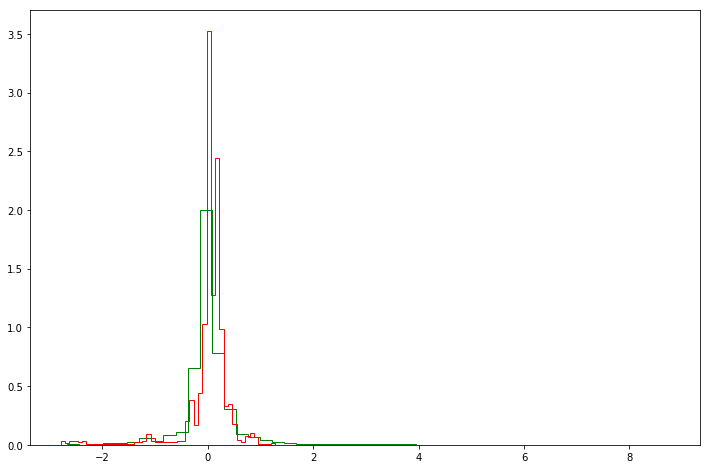

In [7]:
# PDF of train and test 'y' values. 
plt.figure(figsize=(12,8))
plt.hist(train_y, bins=50, normed=1, color='green', histtype ='step');
plt.hist(test_y, bins=50, normed=1, color='red', histtype ='step');
plt.show()


In [8]:
#Model 0: Base line Model: y_test_pred = mean(y_train_i) 
train_mean_y = np.mean(train_y)

print('Test_MSE(MEAN):%f' % np.mean(np.square(test_y-train_mean_y)) )

print('Test_MSE(ZERO):%f' % np.mean(np.square(test_y-0.0)) )


Test_MSE(MEAN):0.191127
Test_MSE(ZERO):0.190891


### 3. Model Architecture

In [9]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W, stride):
  return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

x = tf.placeholder(tf.float32, shape=[None, 66, 200, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

x_image = x

#first convolutional layer
W_conv1 = weight_variable([5, 5, 3, 24])
b_conv1 = bias_variable([24])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1)

#second convolutional layer
W_conv2 = weight_variable([5, 5, 24, 36])
b_conv2 = bias_variable([36])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 2) + b_conv2)

#third convolutional layer
W_conv3 = weight_variable([5, 5, 36, 48])
b_conv3 = bias_variable([48])

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 2) + b_conv3)

#fourth convolutional layer
W_conv4 = weight_variable([3, 3, 48, 64])
b_conv4 = bias_variable([64])

h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4)

#fifth convolutional layer
W_conv5 = weight_variable([3, 3, 64, 64])
b_conv5 = bias_variable([64])

h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, 1) + b_conv5)

#FCL 1
W_fc1 = weight_variable([1152, 1164])
b_fc1 = bias_variable([1164])

h_conv5_flat = tf.reshape(h_conv5, [-1, 1152])
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#FCL 2
W_fc2 = weight_variable([1164, 100])
b_fc2 = bias_variable([100])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

#FCL 3
W_fc3 = weight_variable([100, 50])
b_fc3 = bias_variable([50])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

#FCL 3
W_fc4 = weight_variable([50, 10])
b_fc4 = bias_variable([10])

h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)

h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob)

#Output
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])

y = tf.identity(tf.matmul(h_fc4_drop, W_fc5) + b_fc5)


### 4.Training the Model

In [11]:
LOGDIR = './save'

sess = tf.InteractiveSession()

L2NormConst = 0.001

train_vars = tf.trainable_variables()

loss = tf.reduce_mean(tf.square(tf.subtract(model.y_, model.y))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
sess.run(tf.initialize_all_variables())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()

saver = tf.train.Saver(write_version = saver_pb2.SaverDef.V1)

# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 30
batch_size = 100

# train over the dataset about 30 times
for epoch in range(epochs):
  for i in range(int(driving_data.num_images/batch_size)):
    xs, ys = driving_data.LoadTrainBatch(batch_size)
    train_step.run(feed_dict={model.x: xs, model.y_: ys, model.keep_prob: 0.5})
    if i % 10 == 0:
      xs, ys = driving_data.LoadValBatch(batch_size)
      loss_value = loss.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 0.5})
      print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

    # write logs at every iteration
    summary = merged_summary_op.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 0.5})
    summary_writer.add_summary(summary, epoch * driving_data.num_images/batch_size + i)

    if i % batch_size == 0:
      if not os.path.exists(LOGDIR):
        os.makedirs(LOGDIR)
      checkpoint_path = os.path.join(LOGDIR, "model.ckpt")
      filename = saver.save(sess, checkpoint_path)
  print("Model saved in file: %s" % filename)

print("Run the command line:\n" \
          "--> tensorboard --logdir=./logs " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")


Epoch: 0, Step: 0, Loss: 15.5241
Epoch: 0, Step: 10, Loss: 13.3961
Epoch: 0, Step: 20, Loss: 12.5071
Epoch: 0, Step: 30, Loss: 12.1788
Epoch: 0, Step: 40, Loss: 11.9118
Epoch: 0, Step: 50, Loss: 11.6858
Epoch: 0, Step: 60, Loss: 11.4448
Epoch: 0, Step: 70, Loss: 11.2974
Epoch: 0, Step: 80, Loss: 11.1432
Epoch: 0, Step: 90, Loss: 10.9986
Epoch: 0, Step: 100, Loss: 10.7833
Epoch: 0, Step: 110, Loss: 10.716
Epoch: 0, Step: 120, Loss: 10.8449
Epoch: 0, Step: 130, Loss: 15.9167
Epoch: 0, Step: 140, Loss: 10.2533
Epoch: 0, Step: 150, Loss: 10.1015
Epoch: 0, Step: 160, Loss: 9.9963
Epoch: 0, Step: 170, Loss: 9.85669
Epoch: 0, Step: 180, Loss: 9.77012
Epoch: 0, Step: 190, Loss: 9.59333
Epoch: 0, Step: 200, Loss: 9.64264
Epoch: 0, Step: 210, Loss: 9.40897
Epoch: 0, Step: 220, Loss: 9.22508
Epoch: 0, Step: 230, Loss: 9.18925
Epoch: 0, Step: 240, Loss: 8.99531
Epoch: 0, Step: 250, Loss: 8.91717
Epoch: 0, Step: 260, Loss: 8.79232
Epoch: 0, Step: 270, Loss: 8.75237
Epoch: 0, Step: 280, Loss: 8.6401

Epoch: 2, Step: 310, Loss: 5.4913
Epoch: 2, Step: 320, Loss: 7.97354
Epoch: 2, Step: 330, Loss: 3.81272
Epoch: 2, Step: 340, Loss: 3.77058
Epoch: 2, Step: 350, Loss: 3.75504
Epoch: 2, Step: 360, Loss: 3.72259
Epoch: 2, Step: 370, Loss: 3.68722
Epoch: 2, Step: 380, Loss: 3.66794
Epoch: 2, Step: 390, Loss: 3.77958
Epoch: 2, Step: 400, Loss: 3.57725
Epoch: 2, Step: 410, Loss: 3.54622
Epoch: 2, Step: 420, Loss: 3.54936
Epoch: 2, Step: 430, Loss: 3.46816
Epoch: 2, Step: 440, Loss: 3.45469
Epoch: 2, Step: 450, Loss: 3.45487
Epoch: 2, Step: 460, Loss: 3.45285
Epoch: 2, Step: 470, Loss: 3.43185
Epoch: 2, Step: 480, Loss: 3.46615
Epoch: 2, Step: 490, Loss: 3.31289
Epoch: 2, Step: 500, Loss: 3.28079
Epoch: 2, Step: 510, Loss: 3.23399
Epoch: 2, Step: 520, Loss: 3.20449
Epoch: 2, Step: 530, Loss: 3.18097
Epoch: 2, Step: 540, Loss: 3.15358
Epoch: 2, Step: 550, Loss: 3.12921
Epoch: 2, Step: 560, Loss: 3.09904
Epoch: 2, Step: 570, Loss: 3.08411
Epoch: 2, Step: 580, Loss: 3.04866
Epoch: 2, Step: 590, 

Epoch: 4, Step: 610, Loss: 1.80717
Epoch: 4, Step: 620, Loss: 1.787
Epoch: 4, Step: 630, Loss: 1.78274
Epoch: 4, Step: 640, Loss: 1.80955
Epoch: 4, Step: 650, Loss: 1.7795
Epoch: 4, Step: 660, Loss: 1.82037
Epoch: 4, Step: 670, Loss: 1.78296
Epoch: 4, Step: 680, Loss: 1.73944
Epoch: 4, Step: 690, Loss: 1.70716
Epoch: 4, Step: 700, Loss: 1.69635
Epoch: 4, Step: 710, Loss: 1.6708
Epoch: 4, Step: 720, Loss: 1.66121
Epoch: 4, Step: 730, Loss: 1.65261
Epoch: 4, Step: 740, Loss: 1.64504
Epoch: 4, Step: 750, Loss: 1.63111
Epoch: 4, Step: 760, Loss: 1.62995
Epoch: 4, Step: 770, Loss: 1.61309
Epoch: 4, Step: 780, Loss: 1.60537
Epoch: 4, Step: 790, Loss: 1.60074
Epoch: 4, Step: 800, Loss: 1.59244
Epoch: 4, Step: 810, Loss: 1.60883
Epoch: 4, Step: 820, Loss: 1.59788
Epoch: 4, Step: 830, Loss: 2.03273
Epoch: 4, Step: 840, Loss: 1.96011
Epoch: 4, Step: 850, Loss: 1.64961
Model saved in file: ./save\model.ckpt
Epoch: 5, Step: 500, Loss: 1.55377
Epoch: 5, Step: 510, Loss: 1.53842
Epoch: 5, Step: 520,

Epoch: 6, Step: 910, Loss: 1.03991
Epoch: 6, Step: 920, Loss: 1.03418
Epoch: 6, Step: 930, Loss: 1.0298
Epoch: 6, Step: 940, Loss: 1.02165
Epoch: 6, Step: 950, Loss: 1.03239
Epoch: 6, Step: 960, Loss: 1.01195
Epoch: 6, Step: 970, Loss: 1.02186
Epoch: 6, Step: 980, Loss: 1.05139
Epoch: 6, Step: 990, Loss: 1.00928
Epoch: 6, Step: 1000, Loss: 1.01731
Epoch: 6, Step: 1010, Loss: 1.09363
Epoch: 6, Step: 1020, Loss: 1.35915
Epoch: 6, Step: 1030, Loss: 1.26133
Epoch: 6, Step: 1040, Loss: 1.0731
Epoch: 6, Step: 1050, Loss: 0.981346
Model saved in file: ./save\model.ckpt
Epoch: 7, Step: 700, Loss: 0.982006
Epoch: 7, Step: 710, Loss: 1.03647
Epoch: 7, Step: 720, Loss: 1.41854
Epoch: 7, Step: 730, Loss: 1.88705
Epoch: 7, Step: 740, Loss: 1.34706
Epoch: 7, Step: 750, Loss: 1.01568
Epoch: 7, Step: 760, Loss: 0.93948
Epoch: 7, Step: 770, Loss: 0.95456
Epoch: 7, Step: 780, Loss: 0.956962
Epoch: 7, Step: 790, Loss: 0.938444
Epoch: 7, Step: 800, Loss: 0.952011
Epoch: 7, Step: 810, Loss: 0.983906
Epoch:

Epoch: 8, Step: 1210, Loss: 1.1026
Epoch: 8, Step: 1220, Loss: 0.908248
Epoch: 8, Step: 1230, Loss: 0.735102
Epoch: 8, Step: 1240, Loss: 0.687875
Epoch: 8, Step: 1250, Loss: 0.653859
Model saved in file: ./save\model.ckpt
Epoch: 9, Step: 900, Loss: 0.75267
Epoch: 9, Step: 910, Loss: 1.4359
Epoch: 9, Step: 920, Loss: 2.10821
Epoch: 9, Step: 930, Loss: 0.882168
Epoch: 9, Step: 940, Loss: 0.738837
Epoch: 9, Step: 950, Loss: 0.630324
Epoch: 9, Step: 960, Loss: 0.633942
Epoch: 9, Step: 970, Loss: 0.626689
Epoch: 9, Step: 980, Loss: 0.633765
Epoch: 9, Step: 990, Loss: 0.645681
Epoch: 9, Step: 1000, Loss: 0.668385
Epoch: 9, Step: 1010, Loss: 0.628126
Epoch: 9, Step: 1020, Loss: 0.747587
Epoch: 9, Step: 1030, Loss: 1.01473
Epoch: 9, Step: 1040, Loss: 0.942834
Epoch: 9, Step: 1050, Loss: 1.0327
Epoch: 9, Step: 1060, Loss: 0.652981
Epoch: 9, Step: 1070, Loss: 0.669958
Epoch: 9, Step: 1080, Loss: 0.63311
Epoch: 9, Step: 1090, Loss: 0.698168
Epoch: 9, Step: 1100, Loss: 0.626409
Epoch: 9, Step: 111

Epoch: 11, Step: 1110, Loss: 0.889595
Epoch: 11, Step: 1120, Loss: 0.839731
Epoch: 11, Step: 1130, Loss: 0.503075
Epoch: 11, Step: 1140, Loss: 0.444806
Epoch: 11, Step: 1150, Loss: 0.468857
Epoch: 11, Step: 1160, Loss: 0.447976
Epoch: 11, Step: 1170, Loss: 0.454622
Epoch: 11, Step: 1180, Loss: 0.489803
Epoch: 11, Step: 1190, Loss: 0.471576
Epoch: 11, Step: 1200, Loss: 0.442563
Epoch: 11, Step: 1210, Loss: 0.565119
Epoch: 11, Step: 1220, Loss: 0.828987
Epoch: 11, Step: 1230, Loss: 0.562269
Epoch: 11, Step: 1240, Loss: 0.600159
Epoch: 11, Step: 1250, Loss: 0.443503
Epoch: 11, Step: 1260, Loss: 0.443782
Epoch: 11, Step: 1270, Loss: 0.449783
Epoch: 11, Step: 1280, Loss: 0.456365
Epoch: 11, Step: 1290, Loss: 0.469045
Epoch: 11, Step: 1300, Loss: 5.61568
Epoch: 11, Step: 1310, Loss: 0.654688
Epoch: 11, Step: 1320, Loss: 0.425505
Epoch: 11, Step: 1330, Loss: 0.41675
Epoch: 11, Step: 1340, Loss: 0.418501
Epoch: 11, Step: 1350, Loss: 0.422851
Epoch: 11, Step: 1360, Loss: 0.411887
Epoch: 11, Ste

Epoch: 13, Step: 1410, Loss: 0.73014
Epoch: 13, Step: 1420, Loss: 0.609407
Epoch: 13, Step: 1430, Loss: 0.360723
Epoch: 13, Step: 1440, Loss: 0.363816
Epoch: 13, Step: 1450, Loss: 0.374943
Epoch: 13, Step: 1460, Loss: 0.414278
Epoch: 13, Step: 1470, Loss: 0.61884
Epoch: 13, Step: 1480, Loss: 0.989189
Epoch: 13, Step: 1490, Loss: 6.87342
Epoch: 13, Step: 1500, Loss: 2.76681
Epoch: 13, Step: 1510, Loss: 0.687949
Epoch: 13, Step: 1520, Loss: 0.50976
Epoch: 13, Step: 1530, Loss: 0.427934
Epoch: 13, Step: 1540, Loss: 0.333088
Epoch: 13, Step: 1550, Loss: 0.323027
Epoch: 13, Step: 1560, Loss: 0.33801
Epoch: 13, Step: 1570, Loss: 0.327525
Epoch: 13, Step: 1580, Loss: 0.33337
Epoch: 13, Step: 1590, Loss: 0.321843
Epoch: 13, Step: 1600, Loss: 0.323382
Epoch: 13, Step: 1610, Loss: 0.342944
Epoch: 13, Step: 1620, Loss: 0.339918
Epoch: 13, Step: 1630, Loss: 0.329204
Epoch: 13, Step: 1640, Loss: 0.315489
Epoch: 13, Step: 1650, Loss: 0.317924
Epoch: 13, Step: 1660, Loss: 0.317328
Epoch: 13, Step: 16

Epoch: 15, Step: 1670, Loss: 1.45769
Epoch: 15, Step: 1680, Loss: 4.48784
Epoch: 15, Step: 1690, Loss: 0.291122
Epoch: 15, Step: 1700, Loss: 0.282031
Epoch: 15, Step: 1710, Loss: 0.280179
Epoch: 15, Step: 1720, Loss: 0.285164
Epoch: 15, Step: 1730, Loss: 0.277376
Epoch: 15, Step: 1740, Loss: 0.276881
Epoch: 15, Step: 1750, Loss: 0.273258
Epoch: 15, Step: 1760, Loss: 0.272122
Epoch: 15, Step: 1770, Loss: 0.273998
Epoch: 15, Step: 1780, Loss: 0.280229
Epoch: 15, Step: 1790, Loss: 0.393422
Epoch: 15, Step: 1800, Loss: 0.339801
Epoch: 15, Step: 1810, Loss: 0.36787
Epoch: 15, Step: 1820, Loss: 0.306802
Epoch: 15, Step: 1830, Loss: 0.274335
Epoch: 15, Step: 1840, Loss: 0.286974
Epoch: 15, Step: 1850, Loss: 0.303418
Epoch: 15, Step: 1860, Loss: 0.521514
Epoch: 15, Step: 1870, Loss: 0.322113
Epoch: 15, Step: 1880, Loss: 0.749555
Epoch: 15, Step: 1890, Loss: 0.449949
Epoch: 15, Step: 1900, Loss: 0.779956
Epoch: 15, Step: 1910, Loss: 0.738593
Epoch: 15, Step: 1920, Loss: 0.3281
Epoch: 15, Step: 

Epoch: 17, Step: 1910, Loss: 0.250791
Epoch: 17, Step: 1920, Loss: 0.26417
Epoch: 17, Step: 1930, Loss: 0.281823
Epoch: 17, Step: 1940, Loss: 0.243461
Epoch: 17, Step: 1950, Loss: 0.241687
Epoch: 17, Step: 1960, Loss: 0.247322
Epoch: 17, Step: 1970, Loss: 0.24553
Epoch: 17, Step: 1980, Loss: 0.257036
Epoch: 17, Step: 1990, Loss: 0.274275
Epoch: 17, Step: 2000, Loss: 0.282098
Epoch: 17, Step: 2010, Loss: 0.239978
Epoch: 17, Step: 2020, Loss: 0.238779
Epoch: 17, Step: 2030, Loss: 0.237625
Epoch: 17, Step: 2040, Loss: 0.239782
Epoch: 17, Step: 2050, Loss: 0.236863
Epoch: 17, Step: 2060, Loss: 0.236003
Epoch: 17, Step: 2070, Loss: 0.235572
Epoch: 17, Step: 2080, Loss: 0.23559
Epoch: 17, Step: 2090, Loss: 0.236249
Epoch: 17, Step: 2100, Loss: 0.234387
Epoch: 17, Step: 2110, Loss: 0.234655
Epoch: 17, Step: 2120, Loss: 0.233657
Epoch: 17, Step: 2130, Loss: 0.232975
Epoch: 17, Step: 2140, Loss: 0.238719
Epoch: 17, Step: 2150, Loss: 0.242928
Model saved in file: ./save\model.ckpt
Epoch: 18, Ste

Epoch: 19, Step: 2210, Loss: 0.217019
Epoch: 19, Step: 2220, Loss: 0.221504
Epoch: 19, Step: 2230, Loss: 0.23223
Epoch: 19, Step: 2240, Loss: 0.219318
Epoch: 19, Step: 2250, Loss: 0.216096
Epoch: 19, Step: 2260, Loss: 0.263813
Epoch: 19, Step: 2270, Loss: 0.330385
Epoch: 19, Step: 2280, Loss: 1.77956
Epoch: 19, Step: 2290, Loss: 1.57296
Epoch: 19, Step: 2300, Loss: 1.16897
Epoch: 19, Step: 2310, Loss: 0.318737
Epoch: 19, Step: 2320, Loss: 0.312924
Epoch: 19, Step: 2330, Loss: 0.240226
Epoch: 19, Step: 2340, Loss: 0.226657
Epoch: 19, Step: 2350, Loss: 0.275183
Model saved in file: ./save\model.ckpt
Epoch: 20, Step: 2000, Loss: 0.28454
Epoch: 20, Step: 2010, Loss: 5.70682
Epoch: 20, Step: 2020, Loss: 0.264523
Epoch: 20, Step: 2030, Loss: 0.213561
Epoch: 20, Step: 2040, Loss: 0.243415
Epoch: 20, Step: 2050, Loss: 0.288296
Epoch: 20, Step: 2060, Loss: 0.287648
Epoch: 20, Step: 2070, Loss: 0.219115
Epoch: 20, Step: 2080, Loss: 0.310652
Epoch: 20, Step: 2090, Loss: 0.259853
Epoch: 20, Step: 

Epoch: 21, Step: 2510, Loss: 0.197341
Epoch: 21, Step: 2520, Loss: 0.196144
Epoch: 21, Step: 2530, Loss: 0.199971
Epoch: 21, Step: 2540, Loss: 0.271937
Epoch: 21, Step: 2550, Loss: 1.03649
Model saved in file: ./save\model.ckpt
Epoch: 22, Step: 2200, Loss: 4.26474
Epoch: 22, Step: 2210, Loss: 0.273158
Epoch: 22, Step: 2220, Loss: 0.330147
Epoch: 22, Step: 2230, Loss: 0.228176
Epoch: 22, Step: 2240, Loss: 0.209973
Epoch: 22, Step: 2250, Loss: 0.227513
Epoch: 22, Step: 2260, Loss: 0.204332
Epoch: 22, Step: 2270, Loss: 0.259713
Epoch: 22, Step: 2280, Loss: 0.205018
Epoch: 22, Step: 2290, Loss: 0.198058
Epoch: 22, Step: 2300, Loss: 0.220283
Epoch: 22, Step: 2310, Loss: 0.206286
Epoch: 22, Step: 2320, Loss: 0.204817
Epoch: 22, Step: 2330, Loss: 0.325206
Epoch: 22, Step: 2340, Loss: 0.834267
Epoch: 22, Step: 2350, Loss: 0.293637
Epoch: 22, Step: 2360, Loss: 0.335319
Epoch: 22, Step: 2370, Loss: 0.237179
Epoch: 22, Step: 2380, Loss: 0.21125
Epoch: 22, Step: 2390, Loss: 0.201189
Epoch: 22, Ste

Epoch: 23, Step: 2750, Loss: 4.03689
Model saved in file: ./save\model.ckpt
Epoch: 24, Step: 2400, Loss: 0.251309
Epoch: 24, Step: 2410, Loss: 0.18827
Epoch: 24, Step: 2420, Loss: 0.238871
Epoch: 24, Step: 2430, Loss: 0.266242
Epoch: 24, Step: 2440, Loss: 0.246036
Epoch: 24, Step: 2450, Loss: 0.216518
Epoch: 24, Step: 2460, Loss: 0.297073
Epoch: 24, Step: 2470, Loss: 0.18978
Epoch: 24, Step: 2480, Loss: 0.199392
Epoch: 24, Step: 2490, Loss: 0.209688
Epoch: 24, Step: 2500, Loss: 0.201837
Epoch: 24, Step: 2510, Loss: 0.193469
Epoch: 24, Step: 2520, Loss: 0.262524
Epoch: 24, Step: 2530, Loss: 0.282665
Epoch: 24, Step: 2540, Loss: 0.260295
Epoch: 24, Step: 2550, Loss: 0.305682
Epoch: 24, Step: 2560, Loss: 0.198566
Epoch: 24, Step: 2570, Loss: 0.212936
Epoch: 24, Step: 2580, Loss: 0.189333
Epoch: 24, Step: 2590, Loss: 0.208923
Epoch: 24, Step: 2600, Loss: 0.259562
Epoch: 24, Step: 2610, Loss: 0.284934
Epoch: 24, Step: 2620, Loss: 0.253142
Epoch: 24, Step: 2630, Loss: 0.213819
Epoch: 24, Ste

Epoch: 26, Step: 2620, Loss: 0.202059
Epoch: 26, Step: 2630, Loss: 0.201617
Epoch: 26, Step: 2640, Loss: 0.237717
Epoch: 26, Step: 2650, Loss: 0.259843
Epoch: 26, Step: 2660, Loss: 0.176088
Epoch: 26, Step: 2670, Loss: 0.188478
Epoch: 26, Step: 2680, Loss: 0.18735
Epoch: 26, Step: 2690, Loss: 0.183064
Epoch: 26, Step: 2700, Loss: 0.268638
Epoch: 26, Step: 2710, Loss: 2.00839
Epoch: 26, Step: 2720, Loss: 0.488086
Epoch: 26, Step: 2730, Loss: 0.306343
Epoch: 26, Step: 2740, Loss: 1.03165
Epoch: 26, Step: 2750, Loss: 0.34881
Epoch: 26, Step: 2760, Loss: 0.807746
Epoch: 26, Step: 2770, Loss: 0.424547
Epoch: 26, Step: 2780, Loss: 0.542135
Epoch: 26, Step: 2790, Loss: 0.391825
Epoch: 26, Step: 2800, Loss: 0.180804
Epoch: 26, Step: 2810, Loss: 0.191209
Epoch: 26, Step: 2820, Loss: 0.191395
Epoch: 26, Step: 2830, Loss: 0.19405
Epoch: 26, Step: 2840, Loss: 0.197733
Epoch: 26, Step: 2850, Loss: 0.198291
Epoch: 26, Step: 2860, Loss: 0.182815
Epoch: 26, Step: 2870, Loss: 0.236594
Epoch: 26, Step: 

Epoch: 28, Step: 2910, Loss: 0.217077
Epoch: 28, Step: 2920, Loss: 0.279628
Epoch: 28, Step: 2930, Loss: 0.224437
Epoch: 28, Step: 2940, Loss: 0.204167
Epoch: 28, Step: 2950, Loss: 0.184296
Epoch: 28, Step: 2960, Loss: 0.183031
Epoch: 28, Step: 2970, Loss: 0.191303
Epoch: 28, Step: 2980, Loss: 0.283318
Epoch: 28, Step: 2990, Loss: 0.178684
Epoch: 28, Step: 3000, Loss: 0.170444
Epoch: 28, Step: 3010, Loss: 0.170881
Epoch: 28, Step: 3020, Loss: 0.178497
Epoch: 28, Step: 3030, Loss: 0.171007
Epoch: 28, Step: 3040, Loss: 0.180931
Epoch: 28, Step: 3050, Loss: 0.19402
Epoch: 28, Step: 3060, Loss: 0.189548
Epoch: 28, Step: 3070, Loss: 0.243784
Epoch: 28, Step: 3080, Loss: 0.624169
Epoch: 28, Step: 3090, Loss: 0.793791
Epoch: 28, Step: 3100, Loss: 0.39505
Epoch: 28, Step: 3110, Loss: 0.676304
Epoch: 28, Step: 3120, Loss: 1.59291
Epoch: 28, Step: 3130, Loss: 0.1892
Epoch: 28, Step: 3140, Loss: 0.245493
Epoch: 28, Step: 3150, Loss: 0.453962
Epoch: 28, Step: 3160, Loss: 0.733494
Epoch: 28, Step: 

### 5. Visualising the Results

In [21]:
#Run this file in the command prompt
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "save/model.ckpt")

img = cv2.imread('steering_wheel_image.jpg',0)
rows,cols = img.shape

smoothed_angle = 0

cap = cv2.VideoCapture(0)
while(cv2.waitKey(10) != ord('q')):
    ret, frame = cap.read()
    image = scipy.misc.imresize(frame, [66, 200]) / 255.0
    degrees = model.y.eval(feed_dict={model.x: [image], model.keep_prob: 1.0})[0][0] * 180 / scipy.pi
    call("clear")
    print("Predicted steering angle: " + str(degrees) + " degrees")
    cv2.imshow('frame', frame)
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle
    #and the predicted angle
    smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (degrees - smoothed_angle) / abs(degrees - smoothed_angle)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-smoothed_angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    cv2.imshow("steering wheel", dst)

cap.release()
cv2.destroyAllWindows()


### Conclusion:
I have split the data into train(70%) and test(30%), used learning rate of 10^-4 and took keep probability value as 0.5 .
Now I am able to see different steering angles.